In [ ]:
# https://drive.google.com/drive/folders/1hGp3dDqDw78sKpfux1L-qh-JpfH9nyX-?usp=drive_link

In [ ]:
! nvidia-smi

Thu Oct  5 12:15:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf

import cv2
import os

import numpy as np


In [ ]:

labels = ["Black Spot", "Downy Mildew","Fresh Leaf"]
img_size = 32
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:

train = get_data('/content/drive/MyDrive/Data')

<ipython-input-5-d595901d8807>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


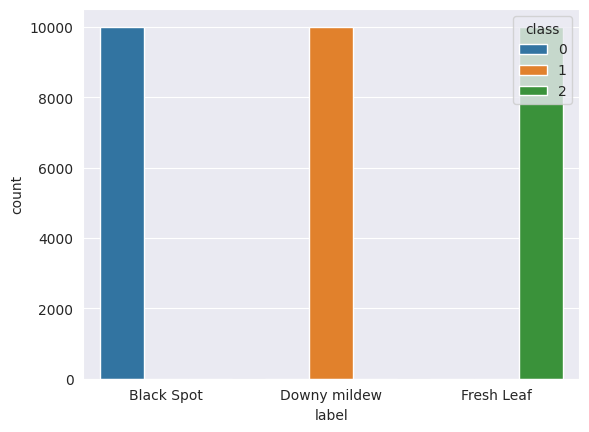

In [ ]:
import pandas as pd

l = []
for i in train:
    if(i[1] == 0):
        l.append("Black Spot")
    elif(i[1] == 1):
          l.append("Downy mildew")
    elif(i[1] == 2):
          l.append("Fresh Leaf")



if len(l) > 0:
    sns.set_style('darkgrid')
    sns.countplot(x="label", hue="class", data=pd.DataFrame({"label": l, "class": train[:, 1]}))
    plt.show()
else:
    print("No data found for the given labels.")

Text(0.5, 1.0, 'Black Spot')

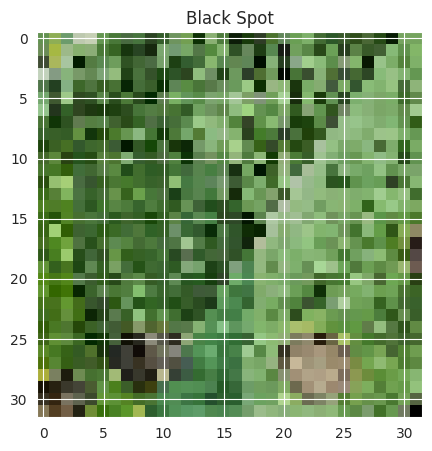

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

In [ ]:
x_train = []
y_train = []


for feature, label in train:
  x_train.append(feature)
  y_train.append(label)
x_train = np.array(x_train) / 255
x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

In [ ]:
print(x_train.shape)

(30000, 32, 32, 3)


In [ ]:
# split with a stratified sampling
from sklearn.model_selection import train_test_split
(x_train, x_test, y_train, y_test) = train_test_split(x_train, y_train,
    test_size=0.20, stratify=y_train, random_state=42)

In [ ]:

!pip install -U -q tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 6.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
num_classes = 3
input_shape = (32, 32, 3)

In [ ]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (24000, 32, 32, 3) - y_train shape: (24000,)
x_test shape: (6000, 32, 32, 3) - y_test shape: (6000,)


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 100
image_size = 32  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 2
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 1
mlp_head_units = [2048, 1024]

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 32 X 32
Patch size: 6 X 6
Patches per image: 25
Elements per patch: 108


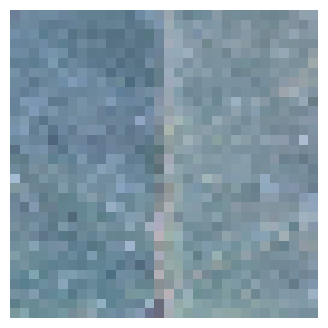

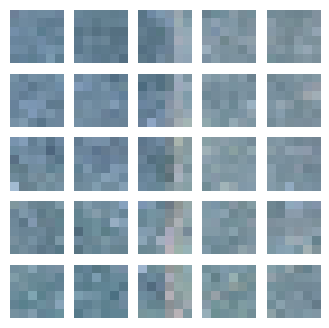

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("float"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("float"))
    plt.axis("off")

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
# Merge inputs and targets
inputs = np.concatenate((x_train, x_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

In [ ]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

In [ ]:
from sklearn.model_selection import KFold

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/100
144/144 [==============================] - 14s 38ms/step - loss: 0.6839 - accuracy: 0.6972 - top-5-accuracy: 1.0000 - val_loss: 0.4511 - val_accuracy: 0.7910 - val_top-5-accuracy: 1.0000
Epoch 2/100
144/144 [==============================] - 3s 24ms/step - loss: 0.4269 - accuracy: 0.8014 - top-5-accuracy: 1.0000 - val_loss: 0.3688 - val_accuracy: 0.8299 - val_top-5-accuracy: 1.0000
Epoch 3/100
144/144 [==============================] - 3s 24ms/step - loss: 0.3373 - accuracy: 0.8517 - top-5-accuracy: 1.0000 - val_loss: 0.3525 - val_accuracy: 0.8377 - val_top-5-accuracy: 1.0000
Epoch 4/100
144/144 [==============================] - 4s 26ms/step - loss: 0.2985 - accuracy: 0.8724 - top-5-accuracy: 1.0000 - val_loss: 0.2816 - val_accuracy: 0.8710 - val_top-5-accuracy: 1.0000
Epoch 5/100
144/144 [==============================] - 4s 25ms/step - loss: 0.2865 - accuracy: 0.8775 - top-5-

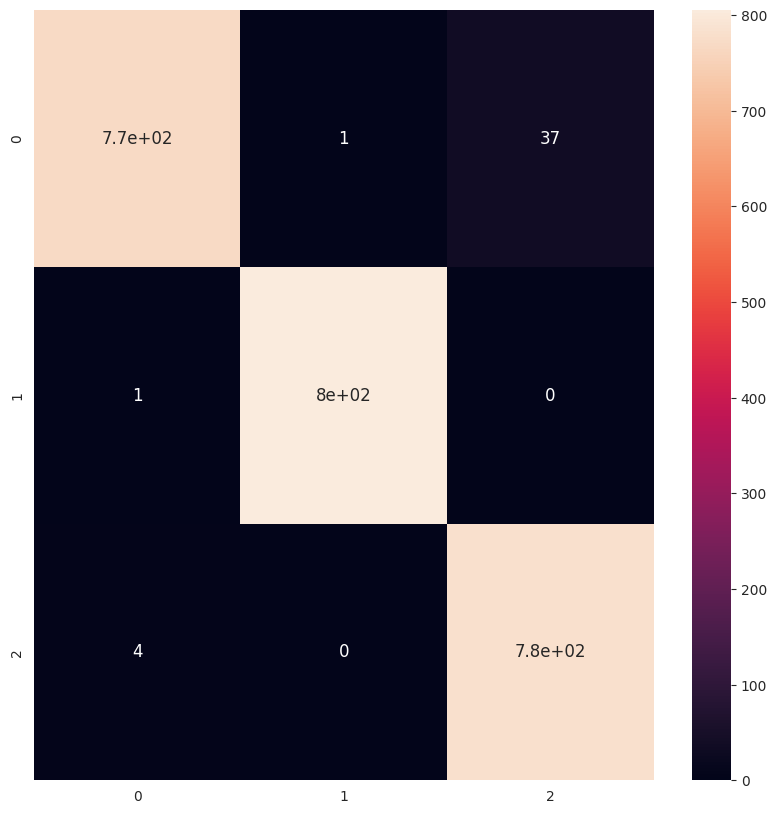

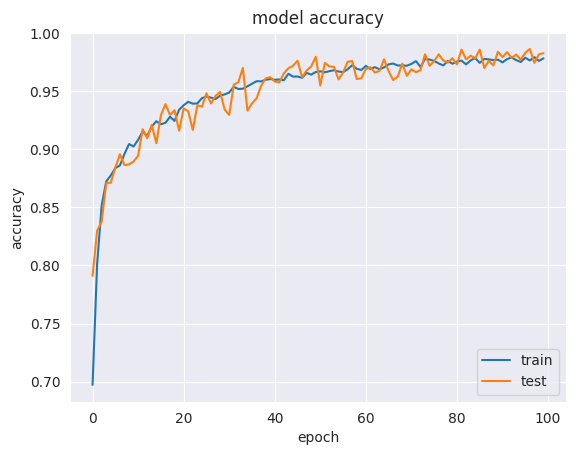

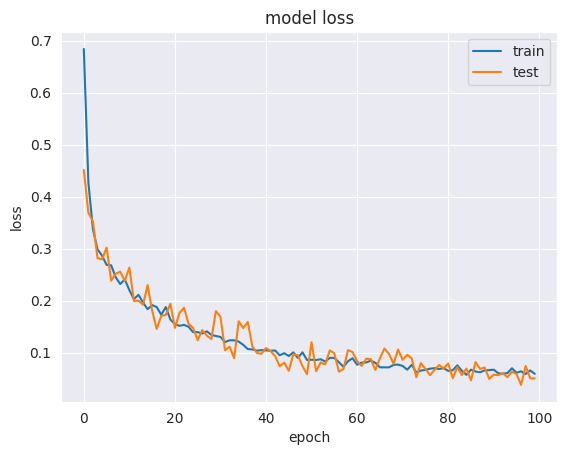

------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/100
144/144 [==============================] - 6s 18ms/step - loss: 0.6914 - accuracy: 0.7059 - top-5-accuracy: 1.0000 - val_loss: 0.4291 - val_accuracy: 0.8003 - val_top-5-accuracy: 1.0000
Epoch 2/100
144/144 [==============================] - 2s 13ms/step - loss: 0.4113 - accuracy: 0.8103 - top-5-accuracy: 1.0000 - val_loss: 0.3581 - val_accuracy: 0.8336 - val_top-5-accuracy: 1.0000
Epoch 3/100
144/144 [==============================] - 2s 12ms/step - loss: 0.3426 - accuracy: 0.8498 - top-5-accuracy: 1.0000 - val_loss: 0.3243 - val_accuracy: 0.8451 - val_top-5-accuracy: 1.0000
Epoch 4/100
144/144 [==============================] - 2s 12ms/step - loss: 0.3117 - accuracy: 0.8641 - top-5-accuracy: 1.0000 - val_loss: 0.3311 - val_accuracy: 0.8515 - val_top-5-accuracy: 1.0000
Epoch 5/100
144/144 [==============================] - 2s 12ms/step - loss: 0.2925 - accuracy: 0.8756 - top-5-a

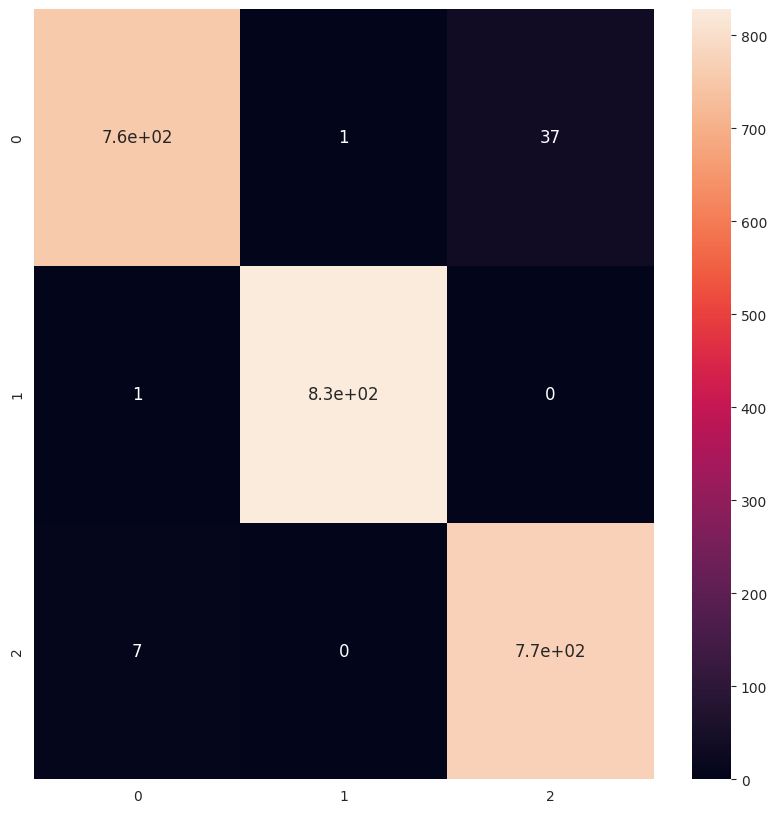

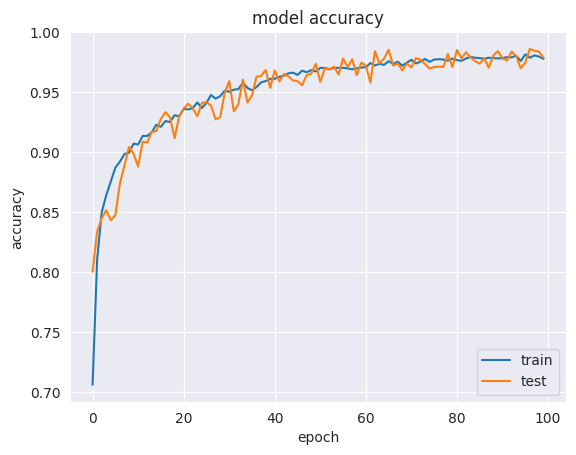

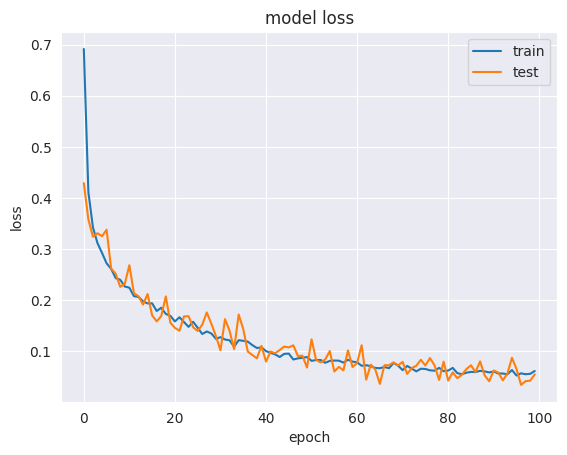

------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/100
144/144 [==============================] - 6s 19ms/step - loss: 0.6521 - accuracy: 0.7129 - top-5-accuracy: 1.0000 - val_loss: 0.4658 - val_accuracy: 0.7525 - val_top-5-accuracy: 1.0000
Epoch 2/100
144/144 [==============================] - 2s 12ms/step - loss: 0.4113 - accuracy: 0.8154 - top-5-accuracy: 1.0000 - val_loss: 0.3418 - val_accuracy: 0.8485 - val_top-5-accuracy: 1.0000
Epoch 3/100
144/144 [==============================] - 2s 13ms/step - loss: 0.3336 - accuracy: 0.8567 - top-5-accuracy: 1.0000 - val_loss: 0.3271 - val_accuracy: 0.8503 - val_top-5-accuracy: 1.0000
Epoch 4/100
144/144 [==============================] - 2s 13ms/step - loss: 0.3031 - accuracy: 0.8705 - top-5-accuracy: 1.0000 - val_loss: 0.2967 - val_accuracy: 0.8710 - val_top-5-accuracy: 1.0000
Epoch 5/100
144/144 [==============================] - 2s 12ms/step - loss: 0.2862 - accuracy: 0.8786 - top-5-a

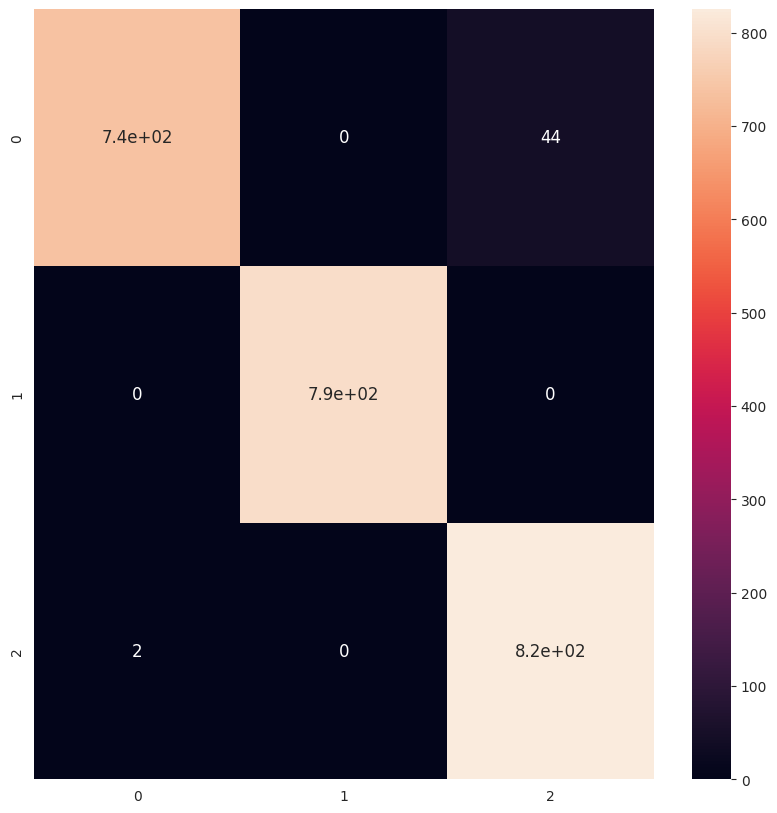

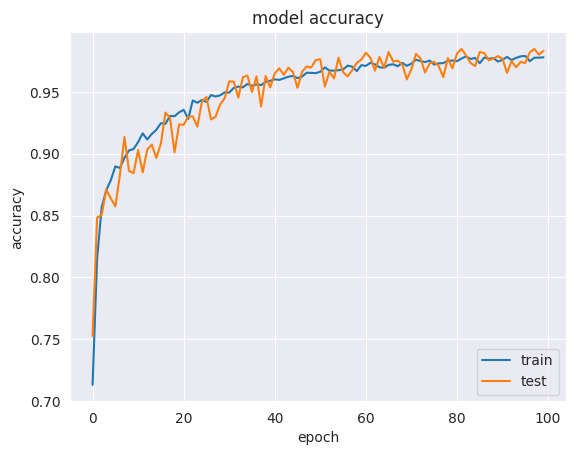

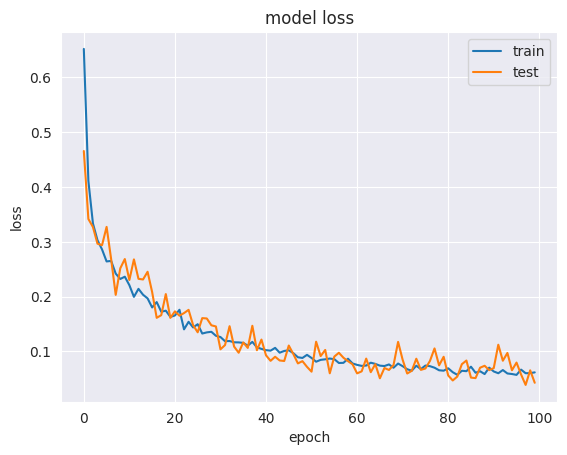

------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/100
144/144 [==============================] - 5s 17ms/step - loss: 0.6808 - accuracy: 0.7054 - top-5-accuracy: 1.0000 - val_loss: 0.4822 - val_accuracy: 0.7522 - val_top-5-accuracy: 1.0000
Epoch 2/100
144/144 [==============================] - 2s 17ms/step - loss: 0.3868 - accuracy: 0.8252 - top-5-accuracy: 1.0000 - val_loss: 0.3343 - val_accuracy: 0.8512 - val_top-5-accuracy: 1.0000
Epoch 3/100
144/144 [==============================] - 3s 18ms/step - loss: 0.3281 - accuracy: 0.8579 - top-5-accuracy: 1.0000 - val_loss: 0.3128 - val_accuracy: 0.8599 - val_top-5-accuracy: 1.0000
Epoch 4/100
144/144 [==============================] - 2s 13ms/step - loss: 0.3061 - accuracy: 0.8664 - top-5-accuracy: 1.0000 - val_loss: 0.2706 - val_accuracy: 0.8812 - val_top-5-accuracy: 1.0000
Epoch 5/100
144/144 [==============================] - 2s 12ms/step - loss: 0.2921 - accuracy: 0.8762 - top-5-a

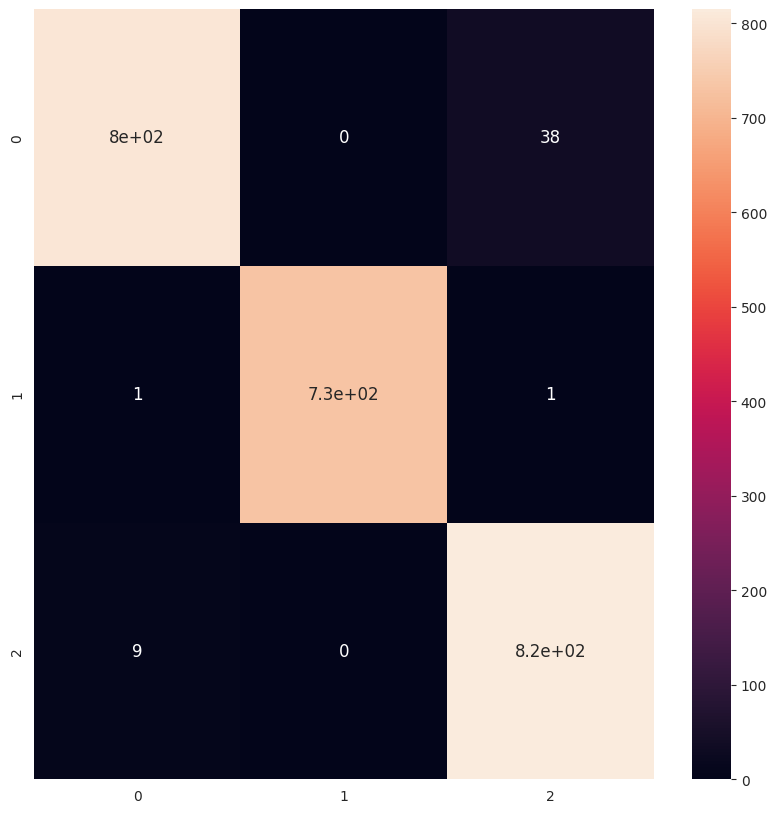

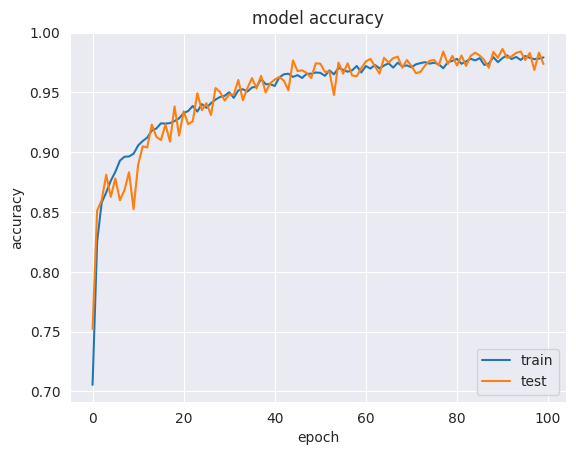

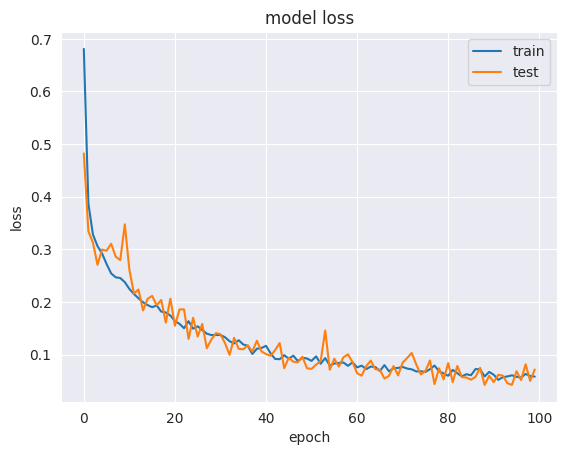

------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/100
144/144 [==============================] - 6s 17ms/step - loss: 0.7000 - accuracy: 0.6964 - top-5-accuracy: 1.0000 - val_loss: 0.4921 - val_accuracy: 0.7515 - val_top-5-accuracy: 1.0000
Epoch 2/100
144/144 [==============================] - 2s 13ms/step - loss: 0.4202 - accuracy: 0.8058 - top-5-accuracy: 1.0000 - val_loss: 0.4090 - val_accuracy: 0.8028 - val_top-5-accuracy: 1.0000
Epoch 3/100
144/144 [==============================] - 2s 13ms/step - loss: 0.3443 - accuracy: 0.8486 - top-5-accuracy: 1.0000 - val_loss: 0.3254 - val_accuracy: 0.8627 - val_top-5-accuracy: 1.0000
Epoch 4/100
144/144 [==============================] - 2s 13ms/step - loss: 0.3029 - accuracy: 0.8661 - top-5-accuracy: 1.0000 - val_loss: 0.2883 - val_accuracy: 0.8775 - val_top-5-accuracy: 1.0000
Epoch 5/100
144/144 [==============================] - 2s 13ms/step - loss: 0.2890 - accuracy: 0.8755 - top-5-a

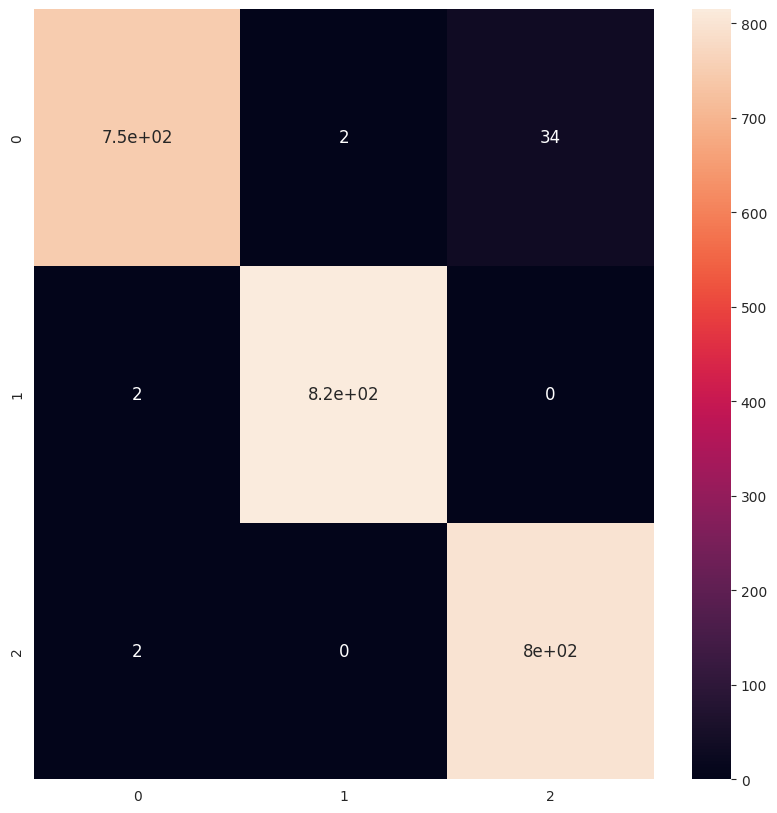

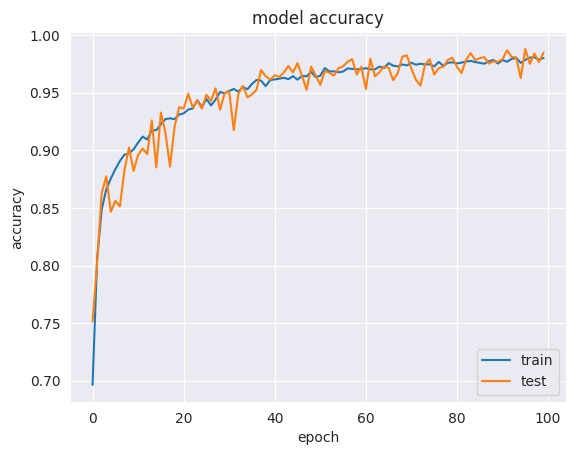

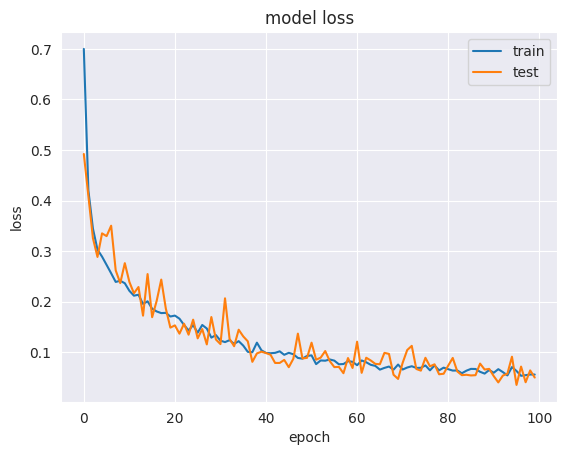

------------------------------------------------------------------------
Training for fold 6 ...
Epoch 1/100
144/144 [==============================] - 5s 17ms/step - loss: 0.6755 - accuracy: 0.7139 - top-5-accuracy: 1.0000 - val_loss: 0.4050 - val_accuracy: 0.8151 - val_top-5-accuracy: 1.0000
Epoch 2/100
144/144 [==============================] - 2s 13ms/step - loss: 0.4006 - accuracy: 0.8204 - top-5-accuracy: 1.0000 - val_loss: 0.3539 - val_accuracy: 0.8407 - val_top-5-accuracy: 1.0000
Epoch 3/100
144/144 [==============================] - 2s 13ms/step - loss: 0.3412 - accuracy: 0.8539 - top-5-accuracy: 1.0000 - val_loss: 0.3934 - val_accuracy: 0.8228 - val_top-5-accuracy: 1.0000
Epoch 4/100
144/144 [==============================] - 2s 14ms/step - loss: 0.3089 - accuracy: 0.8690 - top-5-accuracy: 1.0000 - val_loss: 0.3079 - val_accuracy: 0.8562 - val_top-5-accuracy: 1.0000
Epoch 5/100
144/144 [==============================] - 3s 18ms/step - loss: 0.2889 - accuracy: 0.8783 - top-5-a

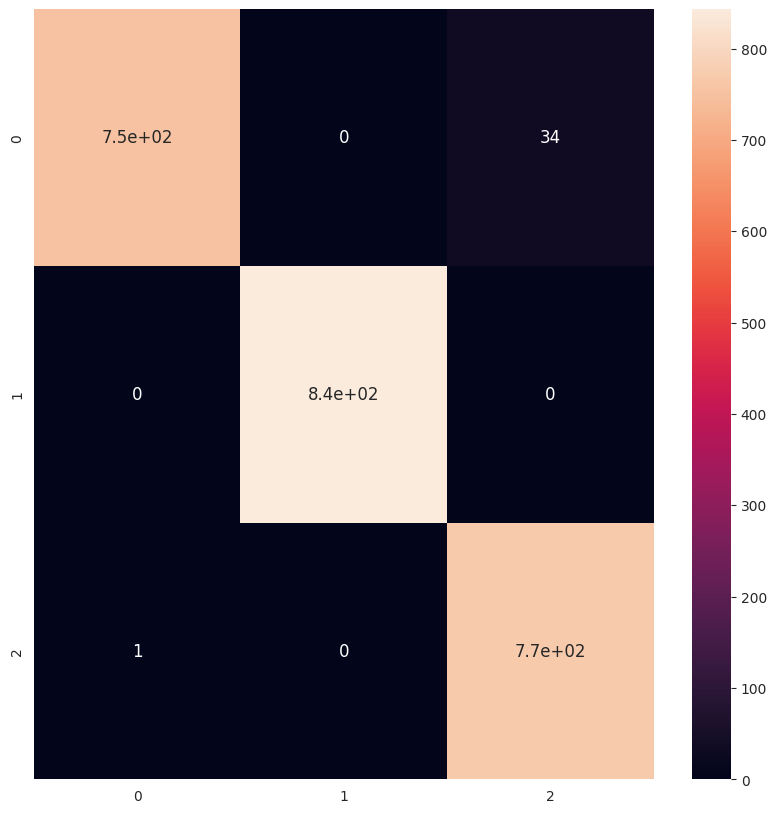

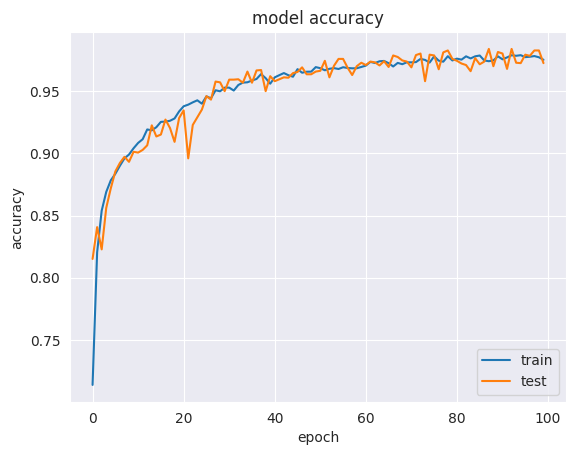

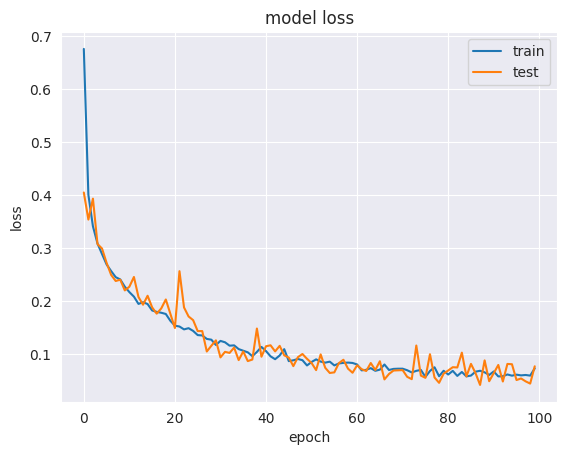

------------------------------------------------------------------------
Training for fold 7 ...
Epoch 1/100
144/144 [==============================] - 6s 17ms/step - loss: 0.6903 - accuracy: 0.7089 - top-5-accuracy: 1.0000 - val_loss: 0.4708 - val_accuracy: 0.7670 - val_top-5-accuracy: 1.0000
Epoch 2/100
144/144 [==============================] - 2s 13ms/step - loss: 0.3996 - accuracy: 0.8218 - top-5-accuracy: 1.0000 - val_loss: 0.3548 - val_accuracy: 0.8423 - val_top-5-accuracy: 1.0000
Epoch 3/100
144/144 [==============================] - 3s 17ms/step - loss: 0.3453 - accuracy: 0.8521 - top-5-accuracy: 1.0000 - val_loss: 0.3290 - val_accuracy: 0.8469 - val_top-5-accuracy: 1.0000
Epoch 4/100
144/144 [==============================] - 3s 18ms/step - loss: 0.3060 - accuracy: 0.8680 - top-5-accuracy: 1.0000 - val_loss: 0.3029 - val_accuracy: 0.8639 - val_top-5-accuracy: 1.0000
Epoch 5/100
144/144 [==============================] - 2s 13ms/step - loss: 0.2913 - accuracy: 0.8734 - top-5-a

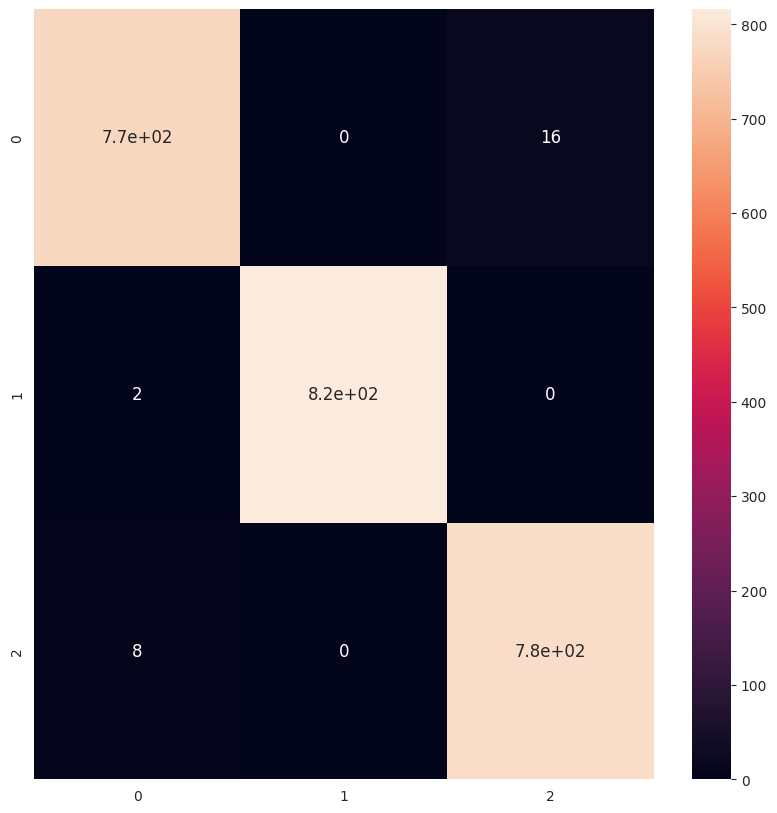

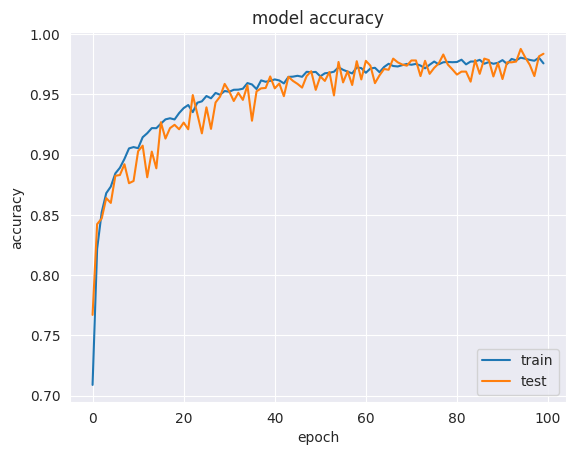

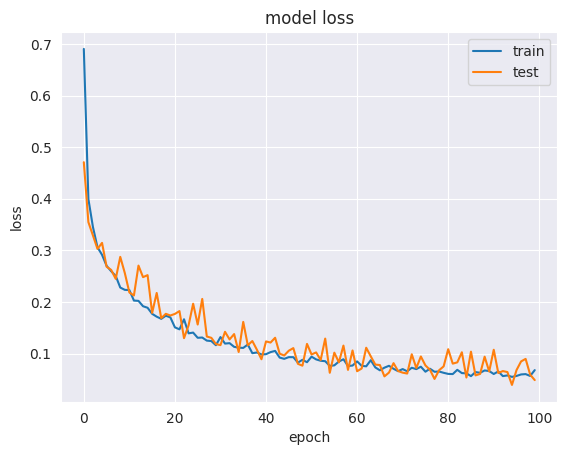

------------------------------------------------------------------------
Training for fold 8 ...
Epoch 1/100
144/144 [==============================] - 5s 17ms/step - loss: 0.6896 - accuracy: 0.7015 - top-5-accuracy: 1.0000 - val_loss: 0.4702 - val_accuracy: 0.7731 - val_top-5-accuracy: 1.0000
Epoch 2/100
144/144 [==============================] - 2s 13ms/step - loss: 0.4246 - accuracy: 0.8043 - top-5-accuracy: 1.0000 - val_loss: 0.3771 - val_accuracy: 0.8265 - val_top-5-accuracy: 1.0000
Epoch 3/100
144/144 [==============================] - 2s 13ms/step - loss: 0.3364 - accuracy: 0.8534 - top-5-accuracy: 1.0000 - val_loss: 0.3904 - val_accuracy: 0.8235 - val_top-5-accuracy: 1.0000
Epoch 4/100
144/144 [==============================] - 2s 17ms/step - loss: 0.3069 - accuracy: 0.8698 - top-5-accuracy: 1.0000 - val_loss: 0.3425 - val_accuracy: 0.8466 - val_top-5-accuracy: 1.0000
Epoch 5/100
144/144 [==============================] - 3s 20ms/step - loss: 0.2828 - accuracy: 0.8797 - top-5-a

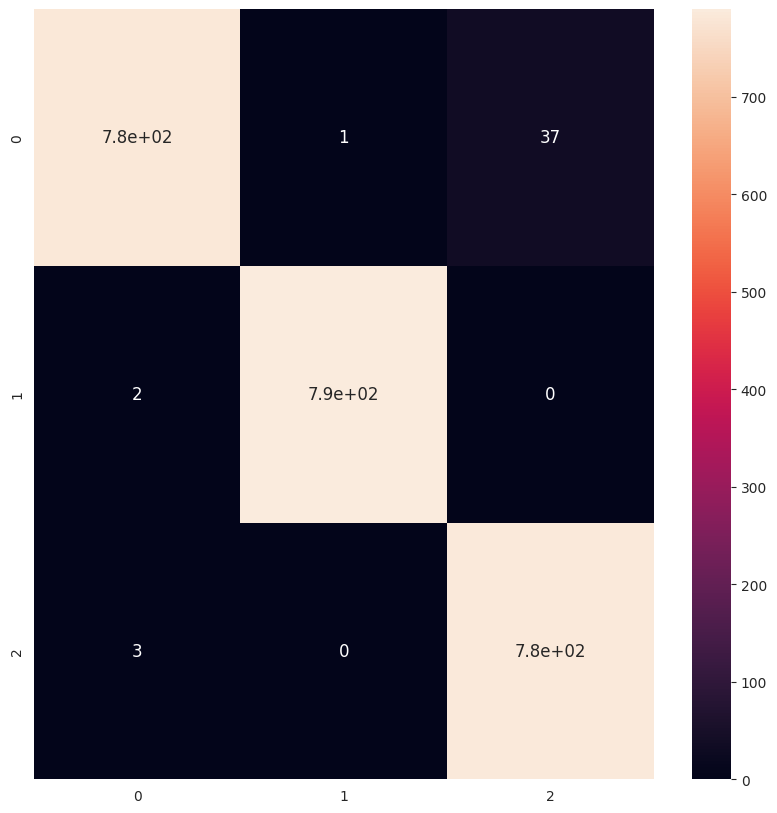

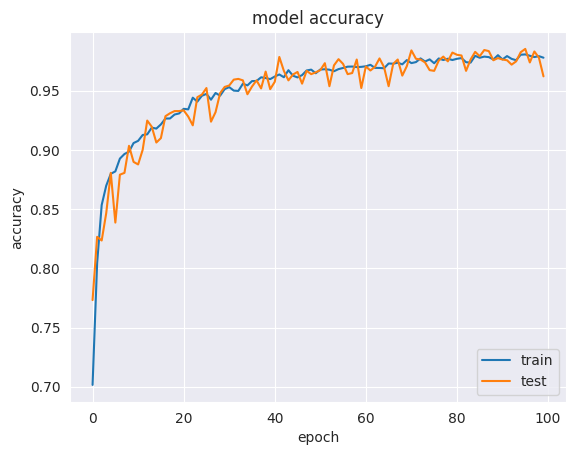

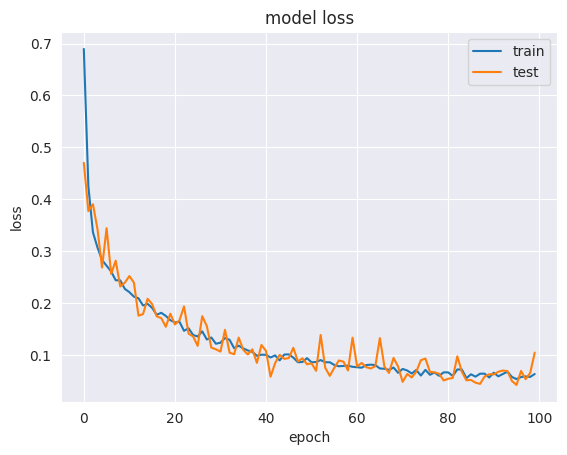

------------------------------------------------------------------------
Training for fold 9 ...
Epoch 1/100
144/144 [==============================] - 6s 19ms/step - loss: 0.6877 - accuracy: 0.7142 - top-5-accuracy: 1.0000 - val_loss: 0.3923 - val_accuracy: 0.8241 - val_top-5-accuracy: 1.0000
Epoch 2/100
144/144 [==============================] - 2s 13ms/step - loss: 0.3635 - accuracy: 0.8345 - top-5-accuracy: 1.0000 - val_loss: 0.3375 - val_accuracy: 0.8451 - val_top-5-accuracy: 1.0000
Epoch 3/100
144/144 [==============================] - 2s 14ms/step - loss: 0.3217 - accuracy: 0.8572 - top-5-accuracy: 1.0000 - val_loss: 0.3070 - val_accuracy: 0.8559 - val_top-5-accuracy: 1.0000
Epoch 4/100
144/144 [==============================] - 2s 13ms/step - loss: 0.3048 - accuracy: 0.8657 - top-5-accuracy: 1.0000 - val_loss: 0.2614 - val_accuracy: 0.8812 - val_top-5-accuracy: 1.0000
Epoch 5/100
144/144 [==============================] - 2s 13ms/step - loss: 0.2779 - accuracy: 0.8818 - top-5-a

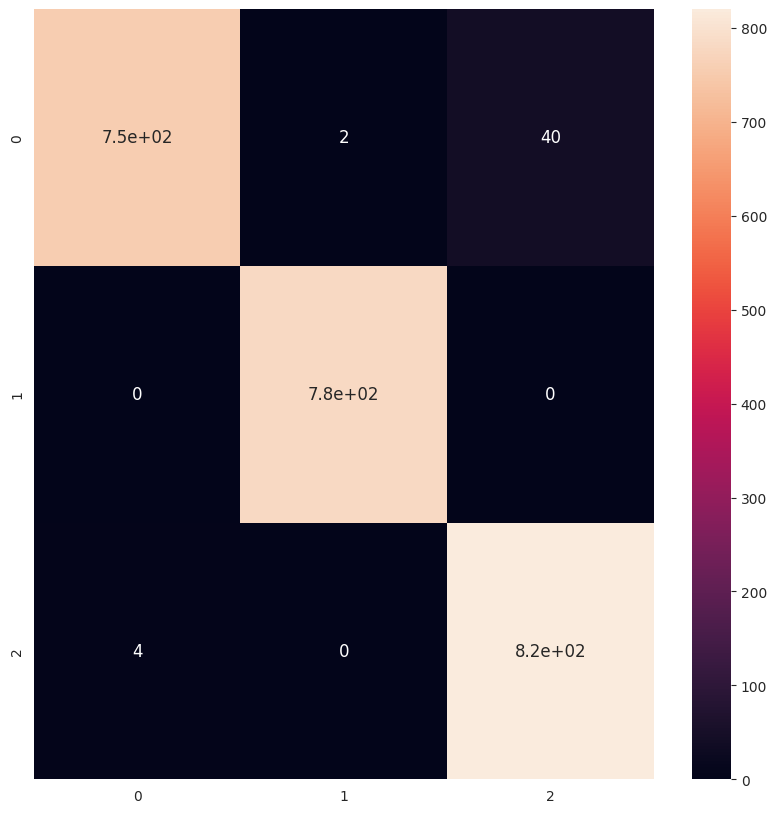

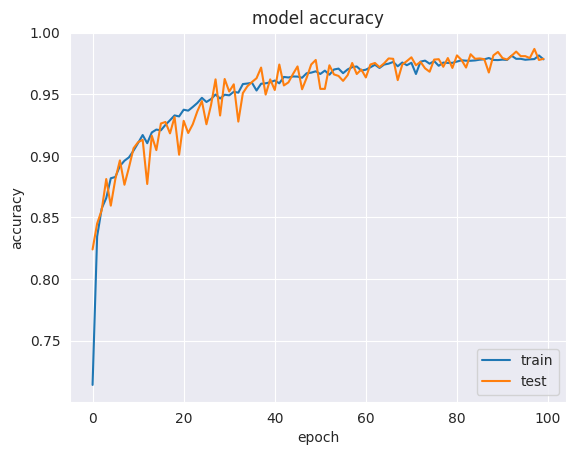

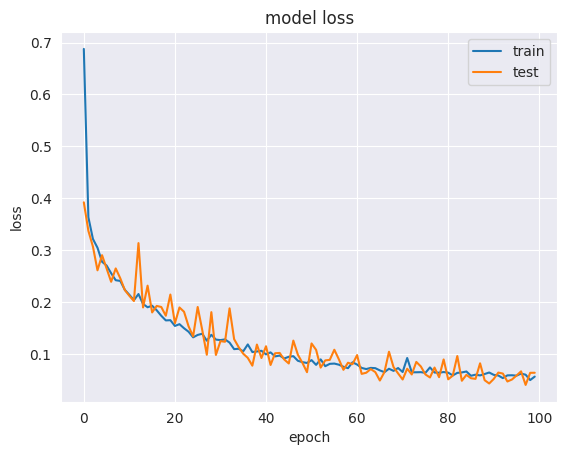

------------------------------------------------------------------------
Training for fold 10 ...
Epoch 1/100
144/144 [==============================] - 6s 22ms/step - loss: 0.6601 - accuracy: 0.7156 - top-5-accuracy: 1.0000 - val_loss: 0.4645 - val_accuracy: 0.7716 - val_top-5-accuracy: 1.0000
Epoch 2/100
144/144 [==============================] - 3s 19ms/step - loss: 0.3910 - accuracy: 0.8225 - top-5-accuracy: 1.0000 - val_loss: 0.3517 - val_accuracy: 0.8519 - val_top-5-accuracy: 1.0000
Epoch 3/100
144/144 [==============================] - 2s 14ms/step - loss: 0.3314 - accuracy: 0.8530 - top-5-accuracy: 1.0000 - val_loss: 0.3158 - val_accuracy: 0.8654 - val_top-5-accuracy: 1.0000
Epoch 4/100
144/144 [==============================] - 2s 13ms/step - loss: 0.3101 - accuracy: 0.8674 - top-5-accuracy: 1.0000 - val_loss: 0.4002 - val_accuracy: 0.8222 - val_top-5-accuracy: 1.0000
Epoch 5/100
144/144 [==============================] - 2s 14ms/step - loss: 0.2831 - accuracy: 0.8781 - top-5-

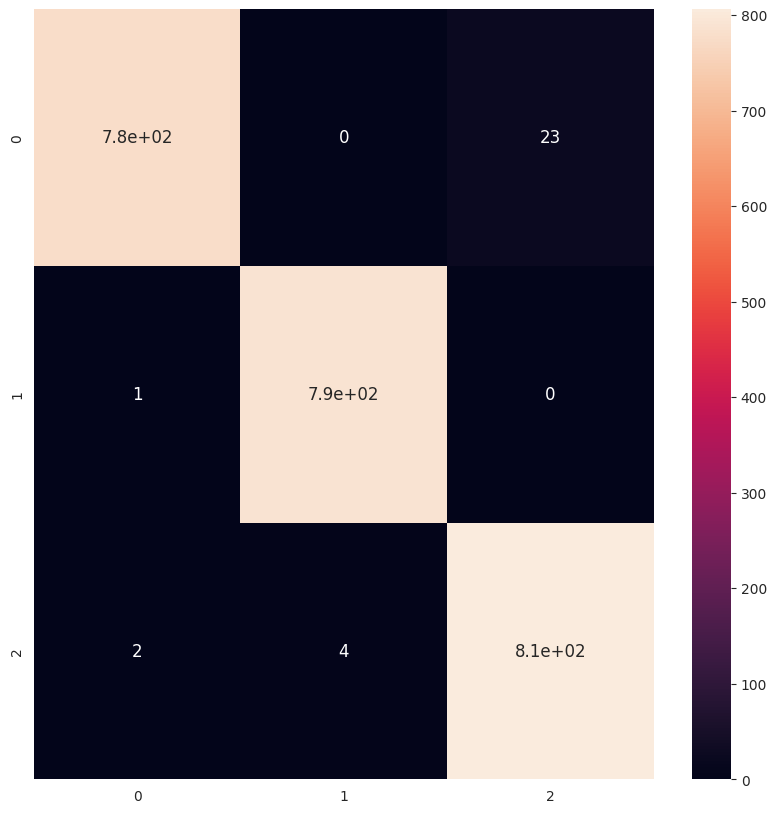

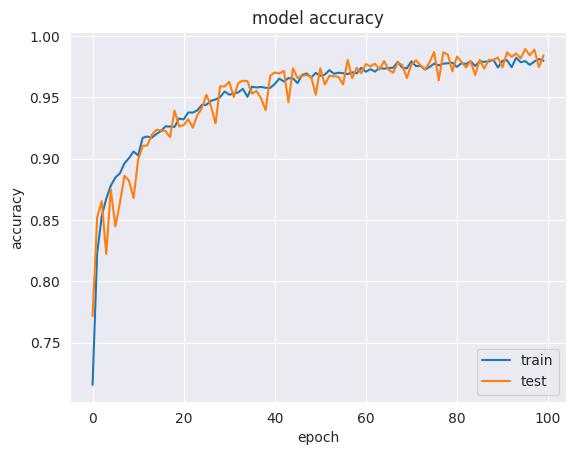

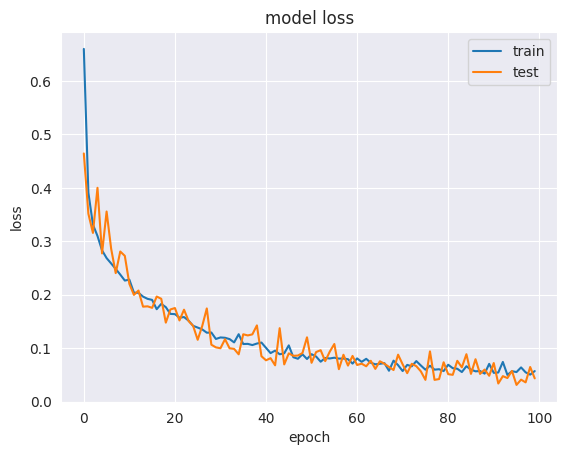

In [ ]:
def run_experiment(model, x_train, y_train, x_test, y_test):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "model.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.15,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # acc_per_fold.append(accuracy[1] * 100)
    # loss_per_fold.append(accuracy[0])

    acc_per_fold.append(accuracy * 100)
    loss_per_fold.append(accuracy)  # Note: Change 'accuracy' to 'loss' if that's your intention









    # Get predictions
    ypred = model.predict(x_test, verbose=1)
    ypred = np.argmax(ypred, axis=1)

    target_names = labels = ["Black Spot", "Downy mildew","Fresh Leaf"]
    print(classification_report(y_test, ypred, target_names=target_names))

    cm = confusion_matrix(y_test, ypred)
    cm = pd.DataFrame(cm, range(3), range(3))
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, annot_kws={"size": 12})
    plt.show()

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

    return history

# Assuming you have loaded your data before this point
kf = KFold(n_splits=10, shuffle=True)

for fold_no, (train_idx, test_idx) in enumerate(kf.split(x_train, y_train), start=1):
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    x_fold_train, y_fold_train = x_train[train_idx], y_train[train_idx]
    x_fold_test, y_fold_test = x_train[test_idx], y_train[test_idx]

    vit_classifier = create_vit_classifier()  # Create a new model for each fold
    history = run_experiment(vit_classifier, x_fold_train, y_fold_train, x_fold_test, y_fold_test)

In [ ]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.9820833206176758 - Accuracy: 98.20833206176758%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.9808333516120911 - Accuracy: 98.0833351612091%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.9808333516120911 - Accuracy: 98.0833351612091%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.9795833230018616 - Accuracy: 97.95833230018616%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.9833333492279053 - Accuracy: 98.33333492279053%
------------------------------------------------------------------------
> Fold 6 - Loss: 0.9854166507720947 - Accuracy: 98.54166507720947%
------------------------------------------------------------------------
>

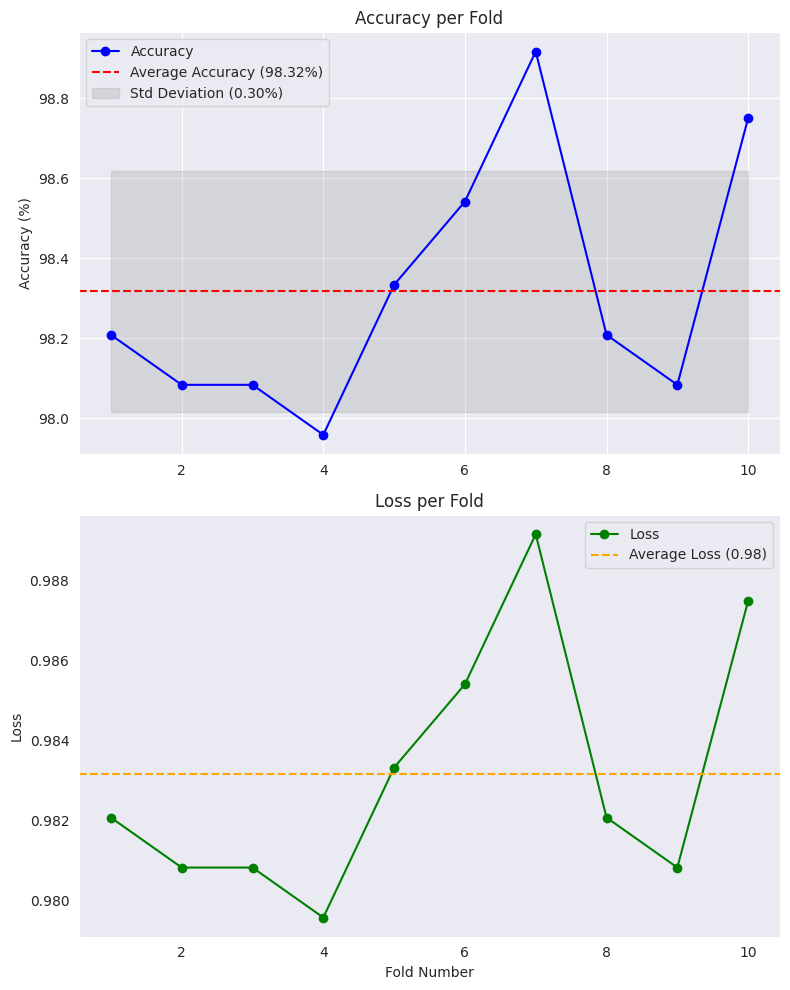

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Your existing code for printing scores

# Collect the average accuracy and loss scores
average_acc = np.mean(acc_per_fold)
std_acc = np.std(acc_per_fold)
average_loss = np.mean(loss_per_fold)

# Create a list of fold numbers
fold_numbers = range(1, len(acc_per_fold) + 1)

# Create subplots for accuracy and loss
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot accuracy
ax1.plot(fold_numbers, acc_per_fold, marker='o', linestyle='-', color='b', label='Accuracy')
ax1.axhline(average_acc, color='r', linestyle='--', label=f'Average Accuracy ({average_acc:.2f}%)')
ax1.fill_between(fold_numbers, average_acc - std_acc, average_acc + std_acc, color='gray', alpha=0.2, label=f'Std Deviation ({std_acc:.2f}%)')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Accuracy per Fold')
ax1.legend()

# Plot loss
ax2.plot(fold_numbers, loss_per_fold, marker='o', linestyle='-', color='g', label='Loss')
ax2.axhline(average_loss, color='orange', linestyle='--', label=f'Average Loss ({average_loss:.2f})')
ax2.set_xlabel('Fold Number')
ax2.set_ylabel('Loss')
ax2.set_title('Loss per Fold')
ax2.legend()

# Show the plot
plt.tight_layout()
plt.grid()
plt.show()
